In [3]:
from exact_diag import antiperiodic_ham, np, form_basis, quantum_operator, spinful_fermion_basis_1d, reduce_state
from exact_diag import quartet_wavefunction, iso_wavefunction, casimir_dict, find_nk, ham_op_2
import matplotlib.pyplot as plt

# Defining various $S^2$ operators

I need to keep in mind the following:
\begin{align*}
\sum_{k,k'>0}S_{k}^+ S_{k'}^- =& \sum_{k,k'>0}(c_{k\uparrow}^\dagger c_{k\downarrow} + c_{-k\uparrow}^\dagger c_{-k\downarrow})
(c_{k'\downarrow}^\dagger c_{k'\uparrow} + c_{-k'\downarrow}^\dagger c_{-k'\uparrow})\\
=&\sum_{k,k'}c_{k\uparrow}^\dagger c_{k\downarrow}c_{k'\downarrow}^\dagger c_{k'\uparrow}
=\sum_{k,k'}c_{k\uparrow}^\dagger c_{k'\uparrow} c_{k\downarrow} c_{k'\downarrow}^\dagger\\
\sum_{k,k'>0}S_{k}^z S_{k'}^z =&
\frac{1}{4}\sum_{k,k'>0}(n_{k\uparrow}+ n_{-k\uparrow}-n_{k\downarrow} - n_{-k\downarrow})
(n_{k'\uparrow}+ n_{-k'\uparrow}-n_{k'\downarrow} - n_{-k'\downarrow})\\
=&\frac{1}{4}\sum_{k,k'}(n_{k\uparrow} - n_{k\downarrow})(n_{k'\uparrow} - n_{k'\downarrow})\\
=&\frac{1}{4}\sum_{k,k'}(  n_{k\uparrow} n_{k'\uparrow} 
                         - n_{k\uparrow} n_{k'\downarrow}
                         - n_{k'\uparrow} n_{k\downarrow}
                         + n_{k\downarrow} n_{k'\downarrow}).
\end{align*}
Then,
\begin{align*}
\sum_{k,k'>0}\vec S_k \cdot \vec S_{k'}
=& \frac{1}{2}\sum_{k,k'} \left(
c_{k\uparrow}^\dagger c_{k'\uparrow} c_{k\downarrow} c_{k'\downarrow}^\dagger
+ c_{k\uparrow} c_{k'\uparrow}^\dagger c_{k\downarrow}^\dagger c_{k'\downarrow}
+ \frac{1}{2} \left(n_{k\uparrow} n_{k'\uparrow} + n_{k\downarrow} n_{k'\downarrow}
- n_{k\uparrow} n_{k'\downarrow} - n_{k'\uparrow} n_{k\downarrow}\right)
\right)
\end{align*}
The other thing we care about (maybe??) is $\sum_{k>0} S_k^2 = \sum_{k,k'>0}\delta_{kk'}S_k \cdot \vec S_{k'}$:
\begin{align*}
\sum_{k}\vec S_k \cdot \vec S_k
=& \frac{1}{2}
\end{align*}

In [4]:
def sk2(l, k, basis, s=1):
    # Operator for S.S = 0.5(S^+ S^- + S^- S^+) + S^z S^z
    p_k1 = l + k
    m_k1 = l - k - 1
    spm = [[0.5*s, p_k1, p_k1, p_k1, p_k1],
           [0.5*s, p_k1, m_k1, p_k1, m_k1],
           [0.5*s, m_k1, p_k1, m_k1, p_k1],
           [0.5*s, m_k1, m_k1, m_k1, m_k1]]
    sz_p = [[0.25*s, p_k1, p_k1],
            [0.25*s, m_k1, m_k1],
            [0.25*s, p_k1, m_k1],
            [0.25*s, m_k1, p_k1]
           ]
    sz_n = [[-.5*s, p_k1, p_k1],
            [-.5*s, p_k1, m_k1],
            [-.5*s, m_k1, p_k1],
            [-.5*s, m_k1, m_k1]]
    sdict = {'static':[['+-|-+', spm],
                       ['-+|+-', spm],
                       ['nn|', sz_p],
                       ['|nn', sz_p],
                       ['n|n', sz_n]]}
    return quantum_operator(sdict, basis=basis)


def total_S2_op(L, basis, s=1.):
    op_lst = []
    for i in range(L):
        for j in range(L):
            op_lst += [['+-|-+', [[s/2, L+i, L+j, L+i, L+j],
                                 [s/2, L+i, L-1-j, L+i, L-1-j],
                                 [s/2, L-1-i, L+j, L-1-i, L+j],
                                 [s/2, L-1-i, L-1-j, L-1-i, L-1-j]]],
                       ['-+|+-', [[s/2, L+i, L+j, L+i, L+j],
                                  [s/2, L+i, L-1-j, L+i, L-1-j],
                                  [s/2, L-1-i, L+j, L-1-i, L+j],
                                  [s/2, L-1-i, L-1-j, L-1-i, L-1-j]]],
                      ['nn|', [[s/4, L+i, L+j],
                               [s/4, L+i, L-1-j],
                               [s/4, L-1-i, L+j],
                               [s/4, L-1-i, L-1-j]]],
                      ['|nn', [[s/4, L+i, L+j],
                               [s/4, L+i, L-1-j],
                               [s/4, L-1-i, L+j],
                               [s/4, L-1-i, L-1-j]]],
                      ['n|n', [[-s/4, L+i, L+j],
                               [-s/4, L+i, L-1-j],
                               [-s/4, L-1-i, L+j],
                               [-s/4, L-1-i, L-1-j],
                               [-s/4, L+j, L+i],
                               [-s/4, L+j, L-1-i],
                               [-s/4, L-1-j, L+i],
                               [-s/4, L-1-j, L-1-i]]]
                      ]
        op = quantum_operator({'static': op_lst}, basis=basis,
                                check_herm=False, check_symm=False,
                                check_pcon=False)    
        return op

## Critical point in the attractive case
We are studying the Hamiltonian
\begin{equation}
H = \sum_k \epsilon_k N_k - G\sum_{k,k'}\eta_k \eta_{k'}\left(
\vec T_k^+ \cdot \vec T_{k'}^-
+ \vec T_k^- \cdot \vec T_{k'}^+
+ \vec S_k \cdot \vec S_{k'}
+ \frac{1}{4}N_k N_{k'}
\right).
\end{equation}
with $\eta_k = \epsilon_k = k$.

For attractive ($G > 0$) couplings, this Hamiltonian has a unique ground state except at the critical point
$G_c = 1/\sum_k\eta_k$, at which point the degeneracy seems to scale logarithmically with $N$.
For $N > 4$, one of the ground state wavefunctions has a quartet form.

In [5]:
def gen_crit_wf(l, Nq, Np, basis, basisf):
    alpha=-.5
    # vacuum state
    v0 = np.zeros(basisf.Ns, dtype=np.complex128)
    v0[-1] = 1
    v = v0/np.linalg.norm(v0)
    # print('Applying quartet creation {} times'.format(Nq))
    creation_lst = []
    # """
    for i in range(l):
        for j in range(l):
            ki_p = l+i
            ki_m = l-i-1
            kj_p = l+j
            kj_m = l-j-1
            creation_lst += [[1, ki_p, ki_m, kj_p, kj_m], #T_1 T_-1
                             [1, kj_p, kj_m, ki_p, ki_m], #T_-1 T_1
                             # t_0k^+ t_0k^+ = 
                             [-alpha, ki_p, kj_p, ki_m, kj_m], # -1
                             [alpha, ki_p, kj_m, ki_m, kj_p],
                             [-alpha, ki_m, kj_m, ki_p, kj_p], # -1
                             [alpha, ki_m, kj_p, ki_p, kj_m]
                             ]
    """
    for i in range(l):
        ki_p = l+i
        ki_m = l-i-1

        creation_lst += [[1, ki_p, ki_m, ki_p, ki_m], #T_1 T_-1
                         [1, ki_p, ki_m, ki_p, ki_m], #T_-1 T_1
                         # t_0k^+ t_0k^+ = 
                         [-alpha, ki_p, ki_p, ki_m, ki_m], # -1
                         [alpha, ki_p, ki_m, ki_m, ki_p],
                         [-alpha, ki_m, ki_m, ki_p, ki_p], # -1
                         [alpha, ki_m, ki_p, ki_p, ki_m]
                         ]
    """
    creation_op = quantum_operator({'static': [['++|++', creation_lst]]}, basis=basisf,
                                   check_herm=False, check_symm=False)
    # nk = find_nk(l, v, basisf)
    # print('Before doing anything')
    # print('sum_k n_k')
    # print(np.sum(nk))
    print('Applying quartet creation {} times'.format(Nq))
    for i in range(Nq):
        v = creation_op.dot(v)
        v *= 1./np.linalg.norm(v)
        nk = find_nk(l, v, basisf)
        print('sum_k n_k')
        print(np.sum(nk))
        
    print('Now applying pair creation {} times'.format(Np))
    sum_t0_l = [['+|+', [[1/np.sqrt(2), l+i, l-i-1] for i in range(l)]],
                ['+|+', [[-1/np.sqrt(2), l-i-1, l+i] for i in range(l)]]]
    sum_t0_o = quantum_operator({'static': sum_t0_l}, basis=basisf,
                                check_herm=False, check_symm=False)
    for i in range(Np):
        v = sum_t0_o.dot(v)
        v *= 1./np.linalg.norm(v)
        nk = find_nk(l, v, basisf)
        # print('sum_k n_k')
        # print(np.sum(nk))
        
    # print('Now projecting to {} fermion basis'.format(4*Nq + 2*Np))
    return reduce_state(v, basisf, basis), v


def jorges_wf(l, Nm1, N0, N1, basis, basisf):
    # vacuum state
    v0 = np.zeros(basisf.Ns, dtype=np.complex128)
    v0[-1] = 1
    v = v0/np.linalg.norm(v0)
    if N1 != 0:
        sum_t1_l = [['++|', [[1, l+i, l-i-1] for i in range(l)]]]
        sum_t1_o = quantum_operator({'static': sum_t1_l}, basis=basisf, check_herm=False, check_symm=False)

        for i in range(N1):
            v = sum_t1_o.dot(v)
            v *= 1./np.linalg.norm(v)
            nk = find_nk(l, v, basisf)
            # print('sum_k n_k')
            # print(np.sum(nk))
    if Nm1 != 0:
        sum_tm1_l = [['|++', [[1, l+i, l-i-1] for i in range(l)]]]
        sum_tm1_o = quantum_operator({'static': sum_tm1_l}, basis=basisf, check_herm=False, check_symm=False)
        for i in range(Nm1):
            v = sum_tm1_o.dot(v)
            v *= 1./np.linalg.norm(v)
            nk = find_nk(l, v, basisf)
            # print('sum_k n_k')
            # print(np.sum(nk))
    if N0 != 0:
        sum_t0_l = [['+|+', [[1/np.sqrt(2), l+i, l-i-1] for i in range(l)]],
                    ['+|+', [[-1/np.sqrt(2), l-i-1, l+i] for i in range(l)]]]
        sum_t0_o = quantum_operator({'static': sum_t0_l}, basis=basisf, check_herm=False, check_symm=False)
        for i in range(N0):
            v = sum_t0_o.dot(v)
            v *= 1./np.linalg.norm(v)
            nk = find_nk(l, v, basisf)
            # print('sum_k n_k')
            # print(np.sum(nk))
        
    # print('Now projecting to {} fermion basis'.format(N))
    v_out = reduce_state(v, basisf, basis)
    nk = find_nk(l, v_out, basis)
    # print('sum_k n_k')
    # print(np.sum(nk))
    return v_out, v

def quartet_op(l, basisf):
    alpha=-0.5
    creation_lst = []
    for i in range(l):
        for j in range(l):
            ki_p = l+i
            ki_m = l-i-1
            kj_p = l+j
            kj_m = l-j-1
            creation_lst += [[1, ki_p, ki_m, kj_p, kj_m], #T_1 T_-1
                             [1, kj_p, kj_m, ki_p, ki_m], #T_-1 T_1
                             # t_0k^+ t_0k^+ = 
                             [-alpha, ki_p, kj_p, ki_m, kj_m], # -1
                             [alpha, ki_p, kj_m, ki_m, kj_p],
                             [-alpha, ki_m, kj_m, ki_p, kj_p], # -1
                             [alpha, ki_m, kj_p, ki_p, kj_m]
                             ]
    return quantum_operator({'static': [['++|++', creation_lst]]}, basis=basisf,
                                   check_herm=False, check_symm=False)


def T1_op(l, basisf):
    creation_lst = [[1, l+i, l-1-i] for i in range(l)]
    return quantum_operator({'static': [['++|', creation_lst]]}, basis=basisf,
                                   check_herm=False, check_symm=False)

def Sm_op(l, basisf):
    op_lst = [[-1, i, i] for i in range(2*l)]
    return quantum_operator({'static': [['-|+', op_lst]]}, basis=basisf,
                                   check_herm=False, check_symm=False)
    
def sergios_wf(l, Nq, S, M, basisf):
    N = 4*Nq + 2*S
    print('{} Fermions!'.format(N))
    basis = spinful_fermion_basis_1d(2*l, Nf=(N//2, N//2))
    v = np.zeros(basisf.Ns, dtype=np.complex128)
    v[-1] = 1
    v = v/np.linalg.norm(v)
    T1 = T1_op(l, basisf)
    Q = quartet_op(l, basisf)
    Sm = Sm_op(l, basisf)
    print('Applying T^+ {} times'.format(S))
    for i in range(S):
        v = T1.dot(v)
        v *= 1./np.linalg.norm(v)
    print('Applying Nq {} times'.format(Nq))
    for i in range(Nq):
        v = Q.dot(v)
        v *= 1./np.linalg.norm(v)
    # current S^z = S, need to lower the spin (S-M) times
    print('Applying S^- {} times'.format(S-M))
    for i in range(S - M):
        v = Sm.dot(v)
        v *= 1./np.linalg.norm(v)
    nk = find_nk(l, v, basisf)
    print('sum_k n_k')
    print(np.sum(nk))
    print('Now projecting to {} fermion basis'.format(N))
    v_out = reduce_state(v, basisf, basis)
    return v_out, v
    

In [6]:
L = 8
l = L//2
Nup = 2
Ndown = 2
Sz = .5*(Nup-Ndown)
N = Nup+Ndown
if N%2 == 0:
    degen = (N-2*np.abs(Sz)+4)*.25
else:
    degen = N - 2*np.abs(Sz)+2
k = np.arange(1, 2*l+1, 2)*0.5*np.pi/l
Gc = 1./np.sum(k)
basis = spinful_fermion_basis_1d(L, Nf=(Nup, Ndown))

h = antiperiodic_ham(l, Gc, basis)
e, v = h.eigh()

s2_tot = total_S2_op(l, basis)
# ss, _ = s2_tot.eigh()
# print(np.unique(np.round(ss, 2)))
sops = [sk2(l, i, basis, s=1) for i in range(l)]


print('')
print('Degeneracy')
print(len(e[np.abs(e-e[0]) < 10**-6]))
print('Prediction')
print(degen)

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!

Degeneracy
2
Prediction
2.0


In [7]:
basisf = spinful_fermion_basis_1d(2*l)
hf = antiperiodic_ham(l, Gc, basisf)
v0 = v[:,0]
v1 = v[:,1]
if N%4 == 0:
    vq = quartet_wavefunction(l, N, basis, basisf)

print('General wavefunction: {} pairs, {} quartets'.format((N%4)//2, N//4))
vg, vgf = gen_crit_wf(l, N//4, (N%4)//2, basis, basisf)
# vg = quartet_wavefunction(l, N, basis, basisf)
vg *= 1./np.linalg.norm(vg)

vs1, vsf1 = sergios_wf(l, N//4, 0, 0, basisf) # quartet state
vs2, vsf2 = sergios_wf(l, 0, N//2, 0, basisf) # pair state
if N == 8:
    vs3, vsf3 = sergios_wf(l, 1, 2, 0, basisf) # mixed

print('')
print('Energy for v0')
print(h.matrix_ele(v0, v0)/np.vdot(v0, v0))
print('Sum Sk.Skp')
print(s2_tot.matrix_ele(v0, v0))
print('Sum Sk^2')
print(np.sum([sops[i].matrix_ele(v0, v0) for i in range(l)]))

    
print('')
print('Energy for vg')
print(h.matrix_ele(vg, vg))
print('Total Sk.Skp')
print(s2_tot.matrix_ele(vg, vg))
print('Total Sk^2')
print(np.sum([sops[i].matrix_ele(vg, vg) for i in range(l)]))
 
    
print('')
print('Energy for vs1')
print(h.matrix_ele(vs1, vs1))
print('Total Sk.Skp')
print(s2_tot.matrix_ele(vs1, vs1))
print('Total Sk^2')
print(np.sum([sops[i].matrix_ele(vs1, vs1) for i in range(l)]))
      
print('')
print('Energy for vs2')
print(h.matrix_ele(vs2, vs2))
print('Total Sk.Skp')
print(s2_tot.matrix_ele(vs2, vs2))
print('Total Sk^2')
print(np.sum([sops[i].matrix_ele(vs2, vs2) for i in range(l)]))

if N == 8:
    print('')
    print('Energy for vs3')
    print(h.matrix_ele(vs3, vs3))
    print('Total Sk.Skp')
    print(s2_tot.matrix_ele(vs3, vs3))
    print('Total Sk^2')
    print(np.sum([sops[i].matrix_ele(vs3, vs3) for i in range(l)]))

Before doing anything
sum_k n_k
0.0
sum_k n_k
3.999999999999999
General wavefunction: 0 pairs, 1 quartets
Applying quartet creation 1 times
sum_k n_k
4.0
Now applying pair creation 0 times
4 Fermions!
Applying T^+ 0 times
Applying Nq 1 times
Applying S^- 0 times
sum_k n_k
4.0
Now projecting to 4 fermion basis
4 Fermions!
Applying T^+ 2 times
Applying Nq 0 times
Applying S^- 2 times
sum_k n_k
4.000000000000003
Now projecting to 4 fermion basis

Energy for v0
(-6.185010536754907+0j)
Sum Sk.Skp
(0.0529600998357528+0j)
Sum Sk^2
(2.713742310965112+0j)

Energy for vg
(-6.185010536754907+0j)
Total Sk.Skp
0j
Total Sk^2
(2.666666666666667+0j)

Energy for vs1
(-6.185010536754909+0j)
Total Sk.Skp
0j
Total Sk^2
(2.6666666666666683+0j)

Energy for vs2
(-6.185010536754907+0j)
Total Sk.Skp
(1.5000000000000002+0j)
Total Sk^2
(4.000000000000001+0j)


In [8]:
vs = {'vg': vg, 'vs1': vs1, 'vs2':vs2} # , 'vs3':vs3}
sum_sk2 = sops[0]
for i in range(l-1):
    sum_sk2 += sops[i+1]
for vl in vs:
    v = vs[vl]
    print('Is {} an eigenstate?'.format(vl))
    print('of sum(sk)^2?')
    print(np.max(np.abs(s2_tot.matrix_ele(v, v)*v - s2_tot.dot(v))))
    print('of sk^2?')
    for i in range(l):
        print(np.max(np.abs(sops[i].matrix_ele(v, v)*vg - sops[i].dot(v))))
        print(sops[i].matrix_ele(v, v))
    print('of sum(sk^2)')
    print(np.max(np.abs(sum_sk2.matrix_ele(v, v)*vg - sum_sk2.dot(v))))
    print('')

Is vg an eigenstate?
of sum(sk)^2?
0.0
of sk^2?
0.769800358919501
(2.666666666666667+0j)
0.25660011963983365
(0.6666666666666667+0j)
0.25660011963983365
(0.6666666666666667+0j)
0.25660011963983365
(0.6666666666666667+0j)
of sum(sk^2)
0.769800358919501

Is vs1 an eigenstate?
of sum(sk)^2?
0.0
of sk^2?
0.7698003589195013
(2.666666666666668+0j)
0.25660011963983376
(0.6666666666666671+0j)
0.25660011963983376
(0.6666666666666671+0j)
0.25660011963983376
(0.6666666666666671+0j)
of sum(sk^2)
0.7698003589195013

Is vs2 an eigenstate?
of sum(sk)^2?
0.25000000000000006
of sk^2?
1.1547005383792517
(4.000000000000001+0j)
0.42955837819827103
(1.0000000000000002+0j)
0.42955837819827103
(1.0000000000000002+0j)
0.42955837819827103
(1.0000000000000002+0j)
of sum(sk^2)
1.1547005383792517



In [9]:
print(vs1.dot(vs2))
# print(vs1.dot(vs3))
# print(vs2.dot(vs3))

(2.7755575615628914e-17+0j)


In [10]:
def ke_op(l, s, k, basis):
    all_k = np.concatenate((k[::-1], k))
    creation_lst = [[s*all_k[i], i] for i in range(l)]
    return quantum_operator({'static': [['n|', creation_lst], ['|n', creation_lst]]}, basis=basis,
                                   check_herm=False, check_symm=False, check_pcon=False)

Pairing
Heisenberg
dd
dd 2


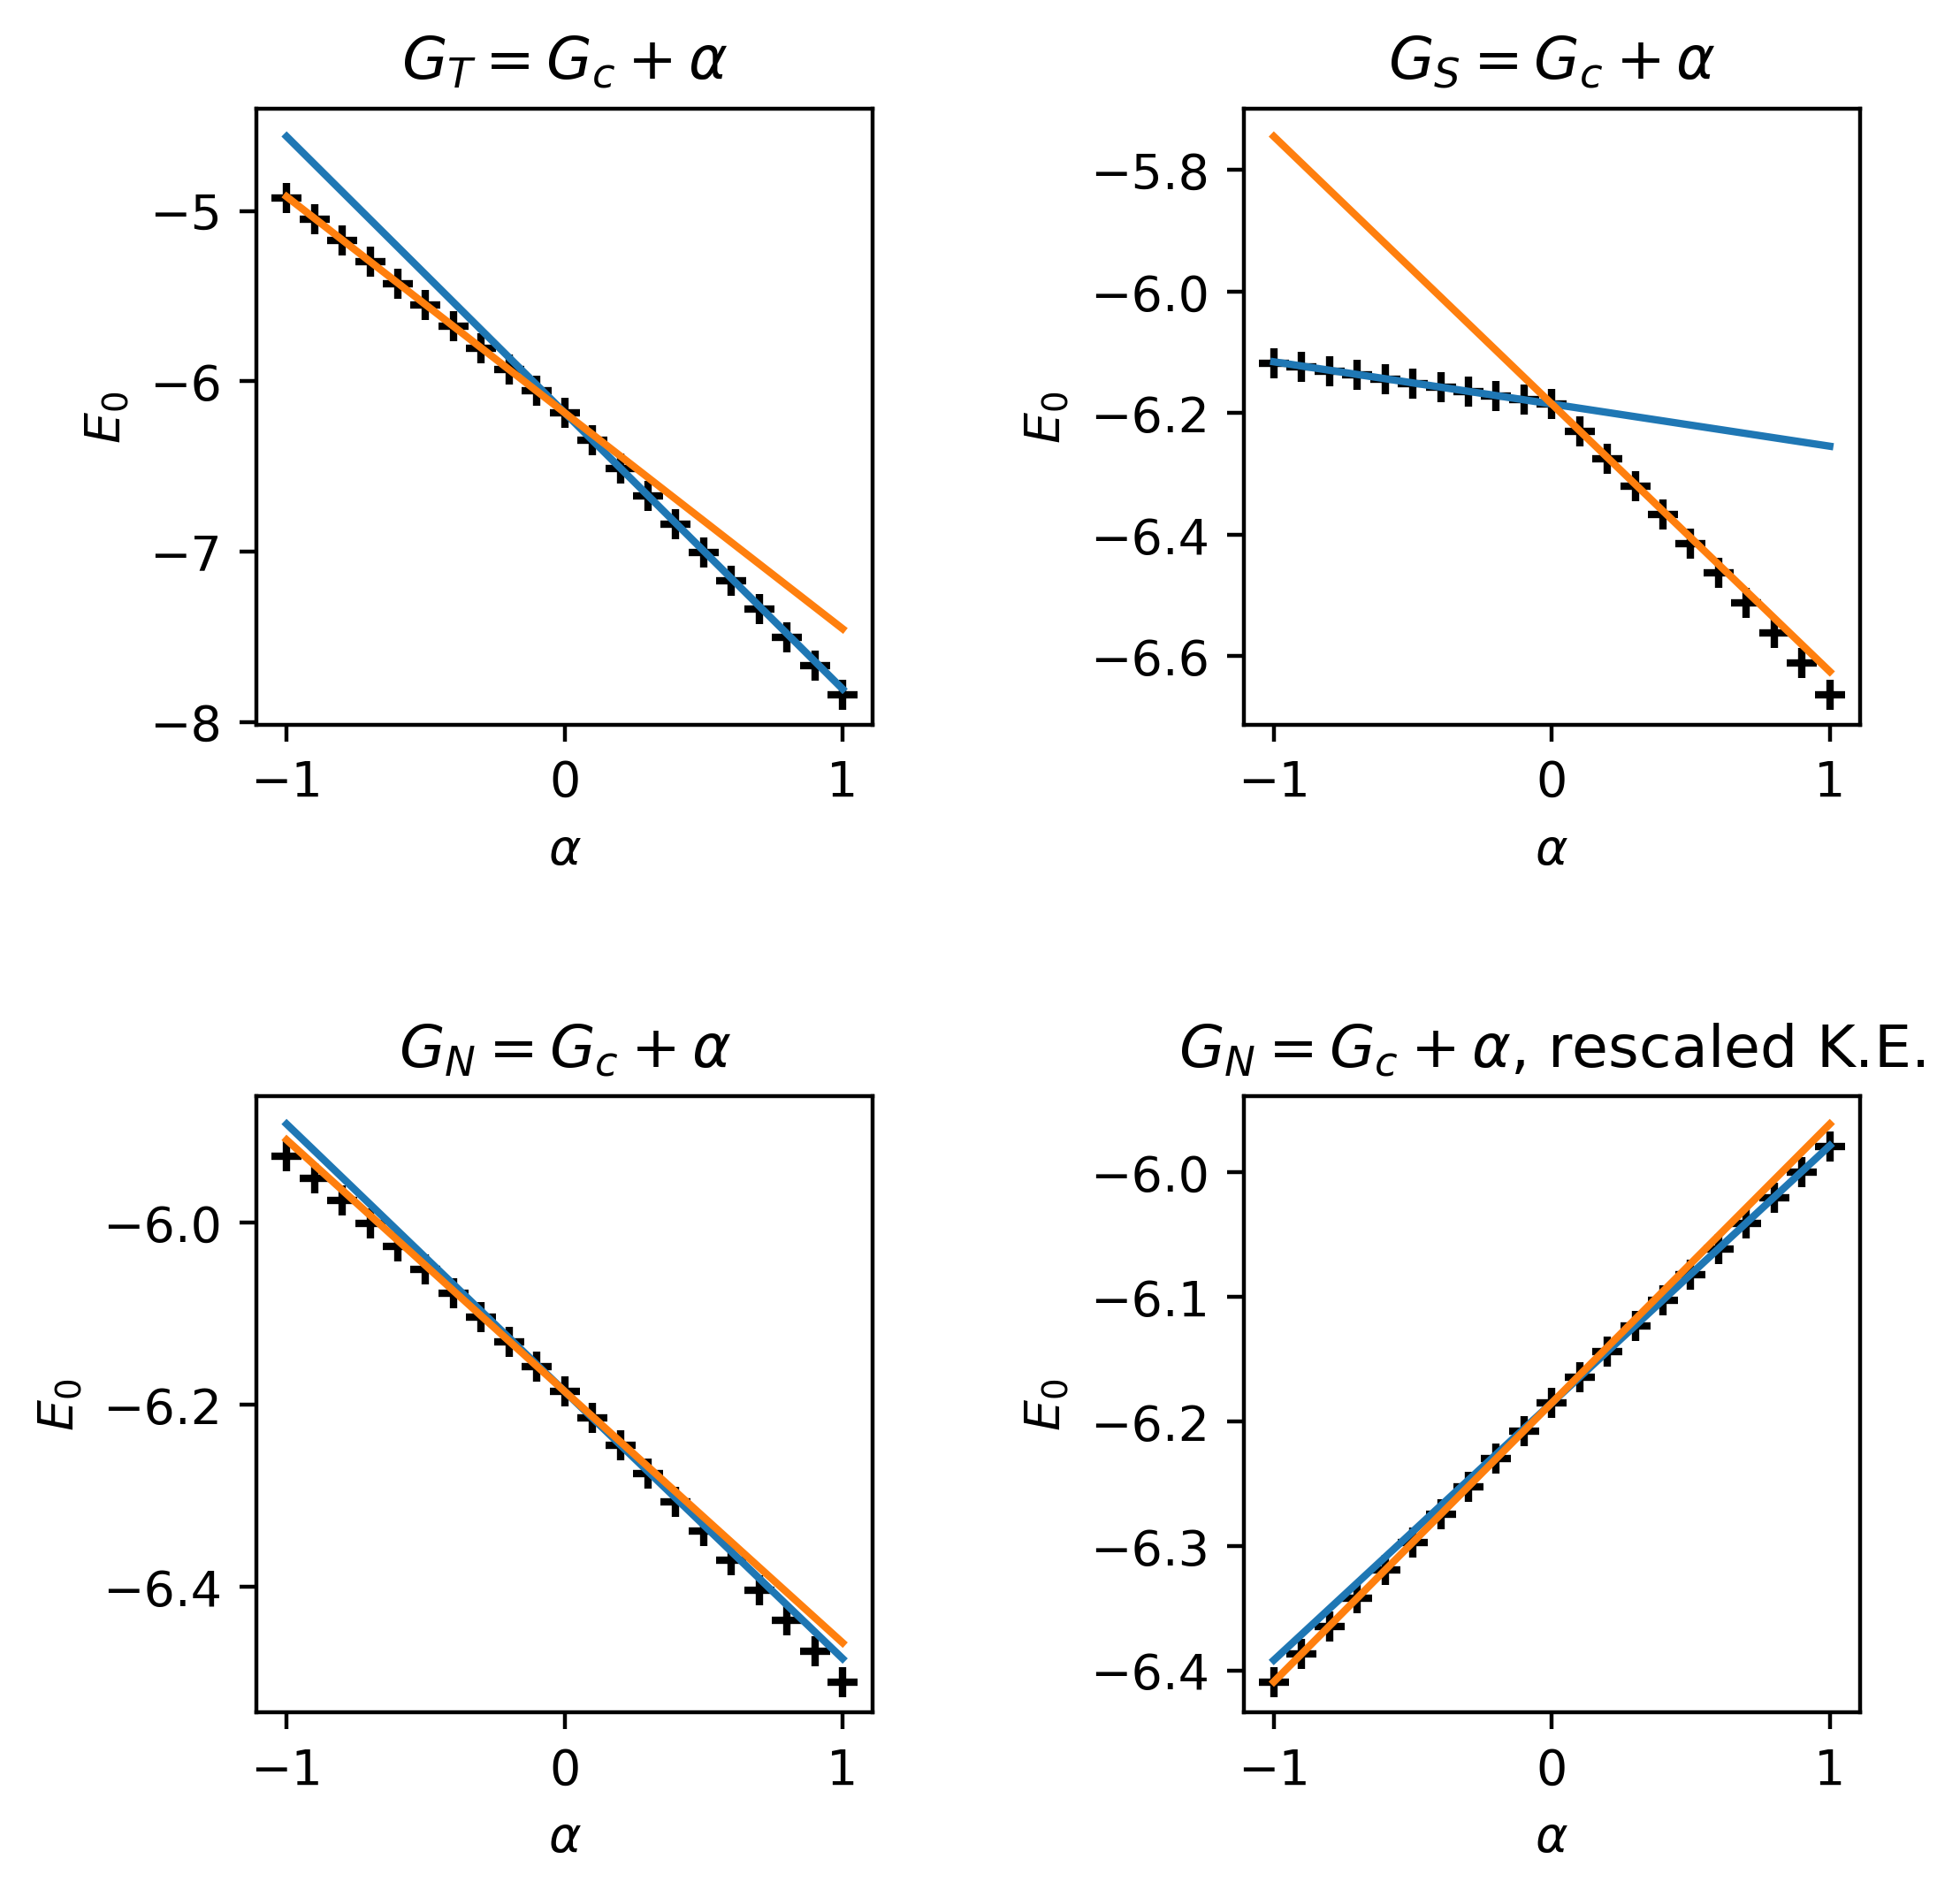

In [16]:
plt.figure(figsize=(6,6), dpi=400)
pscales = np.arange(-1, 1.1, .1)*Gc
labels = ['Gt', 'Gs', 'Gn', 'Gn_2', 'S2']
e0s = {l: np.zeros(len(pscales)) for l in labels}
e1s = {l: np.zeros(len(pscales)) for l in labels}
e2s = {l: np.zeros(len(pscales)) for l in labels}
# e3s = {l: np.zeros(len(pscales)) for l in labels}

for i, p in enumerate(pscales):
    perturb_op = total_S2_op(l, basis, s=p)
    hp = h + perturb_op
    ep, vp = hp.eigh()
    e0s['S2'][i] = ep[0]
    e1s['S2'][i] = np.real(hp.matrix_ele(vs1, vs1))
    e2s['S2'][i] = np.real(hp.matrix_ele(vs2, vs2))    
    # e3s['S2'][i] = np.real(hp.matrix_ele(vs3, vs3))  
    

plt.subplot(2,2,1)
print('Pairing')
for i, p in enumerate(pscales):
    hp = ham_op_2(l, Gc, k, basis, couplings=(1.+p,1,1))
    ep, vp = hp.eigh()
    e0s['Gt'][i] = ep[0]
    e1s['Gt'][i] = np.real(hp.matrix_ele(vs1, vs1))
    e2s['Gt'][i] = np.real(hp.matrix_ele(vs2, vs2))
    # e3s['Gt'][i] = np.real(hp.matrix_ele(vs3, vs3)) 
plt.plot(pscales/Gc, e1s['Gt'], label='Pure quartet')
plt.plot(pscales/Gc, e2s['Gt'], label='Pure pairing')
# plt.plot(pscales/Gc, e3s['Gt'], label='Mixture')
plt.scatter(pscales/Gc, e0s['Gt'], label='True ground state', marker='+', color='black')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$E_0$')
plt.title(r'$G_T = G_c+\alpha$')

    
plt.subplot(2,2,2)
print('Heisenberg')
for i, p in enumerate(pscales):
    hp = ham_op_2(l, Gc, k, basis, couplings=(1,1+p,1))
    ep, vp = hp.eigh()
    e0s['Gs'][i] = ep[0]
    e1s['Gs'][i] = np.real(hp.matrix_ele(vs1, vs1))
    e2s['Gs'][i] = np.real(hp.matrix_ele(vs2, vs2))   
    # e3s['Gs'][i] = np.real(hp.matrix_ele(vs3, vs3)) 
plt.plot(pscales/Gc, e1s['Gs'], label='Pure quartet')
plt.plot(pscales/Gc, e2s['Gs'], label='Pure pairing')
# plt.plot(pscales/Gc, e3s['Gs'], label='Mixture')
plt.scatter(pscales/Gc, e0s['Gs'], label='True ground state', marker='+', color='black')
plt.ylabel(r'$E_0$')
plt.xlabel(r'$\alpha$')
plt.title(r'$G_S = G_c+\alpha$')
    
plt.subplot(2,2,3)
print('dd')
for i, p in enumerate(pscales):
    hp = ham_op_2(l, Gc, k, basis, couplings=(1,1,1+p))
    ep, vp = hp.eigh()
    e0s['Gn'][i] = ep[0]
    e1s['Gn'][i] = np.real(hp.matrix_ele(vs1, vs1))
    e2s['Gn'][i] = np.real(hp.matrix_ele(vs2, vs2))    
    # e3s['Gs'][i] = np.real(hp.matrix_ele(vs3, vs3)) 
plt.plot(pscales/Gc, e1s['Gn'], label='Pure quartet')
plt.plot(pscales/Gc, e2s['Gn'], label='Pure pairing')
# plt.plot(pscales/Gc, e3s['Gn'], label='Mixture')
plt.scatter(pscales/Gc, e0s['Gn'], label='True ground state', marker='+', color='black')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$E_0$')
plt.title(r'$G_N = G_c+\alpha$')

plt.subplot(2,2,4)
print('dd 2')

for i, p in enumerate(pscales):
    hp = ham_op_2(l, Gc, k, basis, couplings=(1,1,1+p))
    hp += ke_op(l, p, k, basis)
    ep, vp = hp.eigh()
    e0s['Gn_2'][i] = ep[0]
    e1s['Gn_2'][i] = np.real(hp.matrix_ele(vs1, vs1))
    e2s['Gn_2'][i] = np.real(hp.matrix_ele(vs2, vs2))
    # e3s['Gn_2'][i] = np.real(hp.matrix_ele(vs3, vs3)) 
plt.plot(pscales/Gc, e1s['Gn_2'], label='Pure quartet')
plt.plot(pscales/Gc, e2s['Gn_2'], label='Pure pairing')
# plt.plot(pscales/Gc, e3s['Gn_2'], label='Mixture')
plt.scatter(pscales/Gc, e0s['Gn_2'], label='True ground state', marker='+', color='black')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$E_0$')
plt.title(r'$G_N = G_c+\alpha$, rescaled K.E.')
plt.tight_layout(pad=3.0)


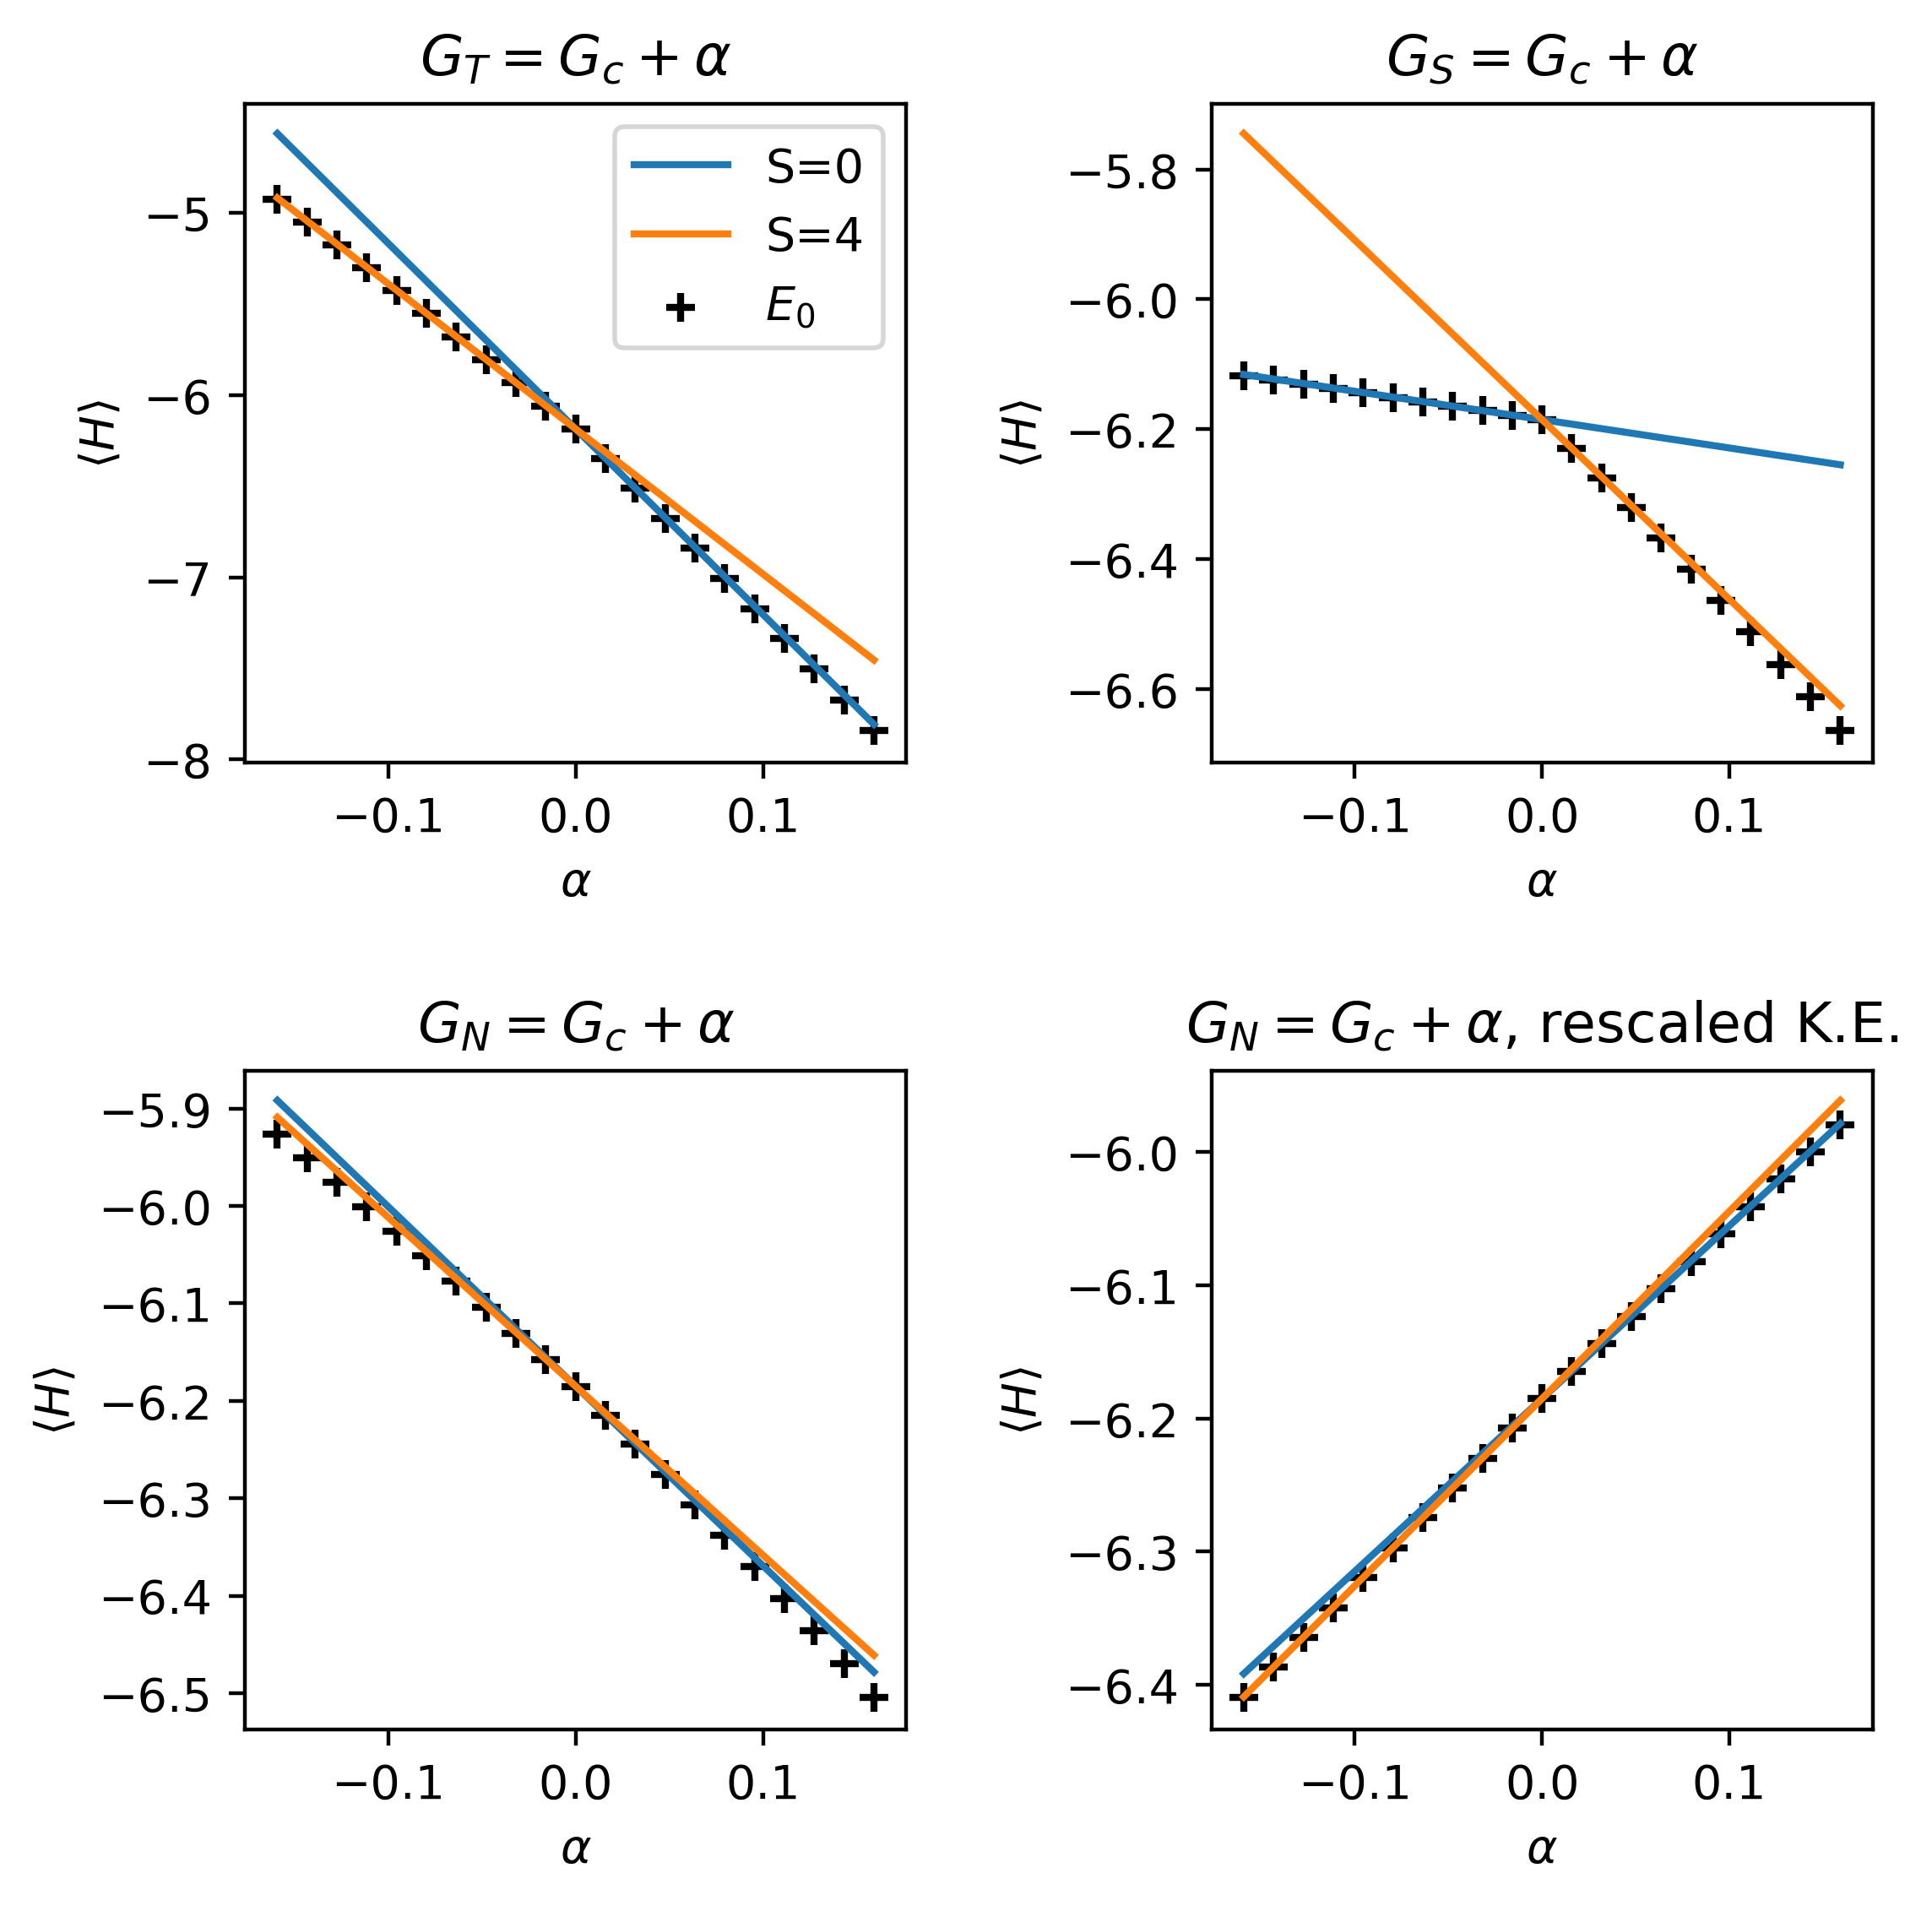

In [17]:
plt.figure(figsize=(6,6), dpi=400)
titles = [r'$G_T = G_c+\alpha$', r'$G_S = G_c+\alpha$', r'$G_N = G_c+\alpha$', r'$G_N = G_c+\alpha$, rescaled K.E.']
for i in range(4):
    la = labels[i]
    plt.subplot(2,2,i+1)
    plt.plot(pscales, e1s[la], label='S=0')
    # plt.plot(pscales, e3s[la], label='S=2')
    plt.plot(pscales, e2s[la], label='S=4')
    plt.scatter(pscales, e0s[la], label='$E_0$', marker='+', color='black')
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\langle H \rangle$')
    if i == 0:
        plt.legend()
    plt.title(titles[i])

plt.tight_layout(pad=2.0)
plt.savefig('/Users/wholdhus/Desktop/SO5_Figs/stabilized_pairons.png', bbox_inches='tight',
            transparent=False)

$G_S = G_c+\alpha$
S=0 diffs
[ 2.35896485e-03  1.91866413e-03  1.52225931e-03  1.17031192e-03
  8.63389920e-04  6.02067709e-04  3.86926054e-04  2.18552037e-04
  9.75389926e-05  2.44864397e-05 -8.88178420e-16  3.74437470e-02
  7.56457705e-02  1.14608661e-01  1.54333008e-01  1.94817434e-01
  2.36058653e-01  2.78051565e-01  3.20789378e-01  3.64263746e-01
  4.08464928e-01]
S=1 diffs
[3.73018687e-01 3.35512414e-01 2.98050037e-01 2.60632117e-01
 2.23259223e-01 1.85931929e-01 1.48650815e-01 1.11416469e-01
 7.42294834e-02 3.70904587e-02 8.88178420e-16 3.77774738e-04
 1.51382602e-03 3.41074403e-03 6.06911938e-03 9.48757301e-03
 1.36628193e-02 1.85897592e-02 2.42616000e-02 3.06699958e-02
 3.78052056e-02]
$G_N = G_c+\alpha$
S=0 diffs
[ 3.48925272e-02  2.98865517e-02  2.52035763e-02  2.08494440e-02
  1.68297086e-02  1.31496009e-02  9.81399595e-03  6.82738227e-03
  4.19383344e-03  1.91698256e-03 -8.88178420e-16  2.66235043e-04
  1.06177049e-03  2.38149139e-03  4.21984977e-03  6.57092324e-03
  9.428

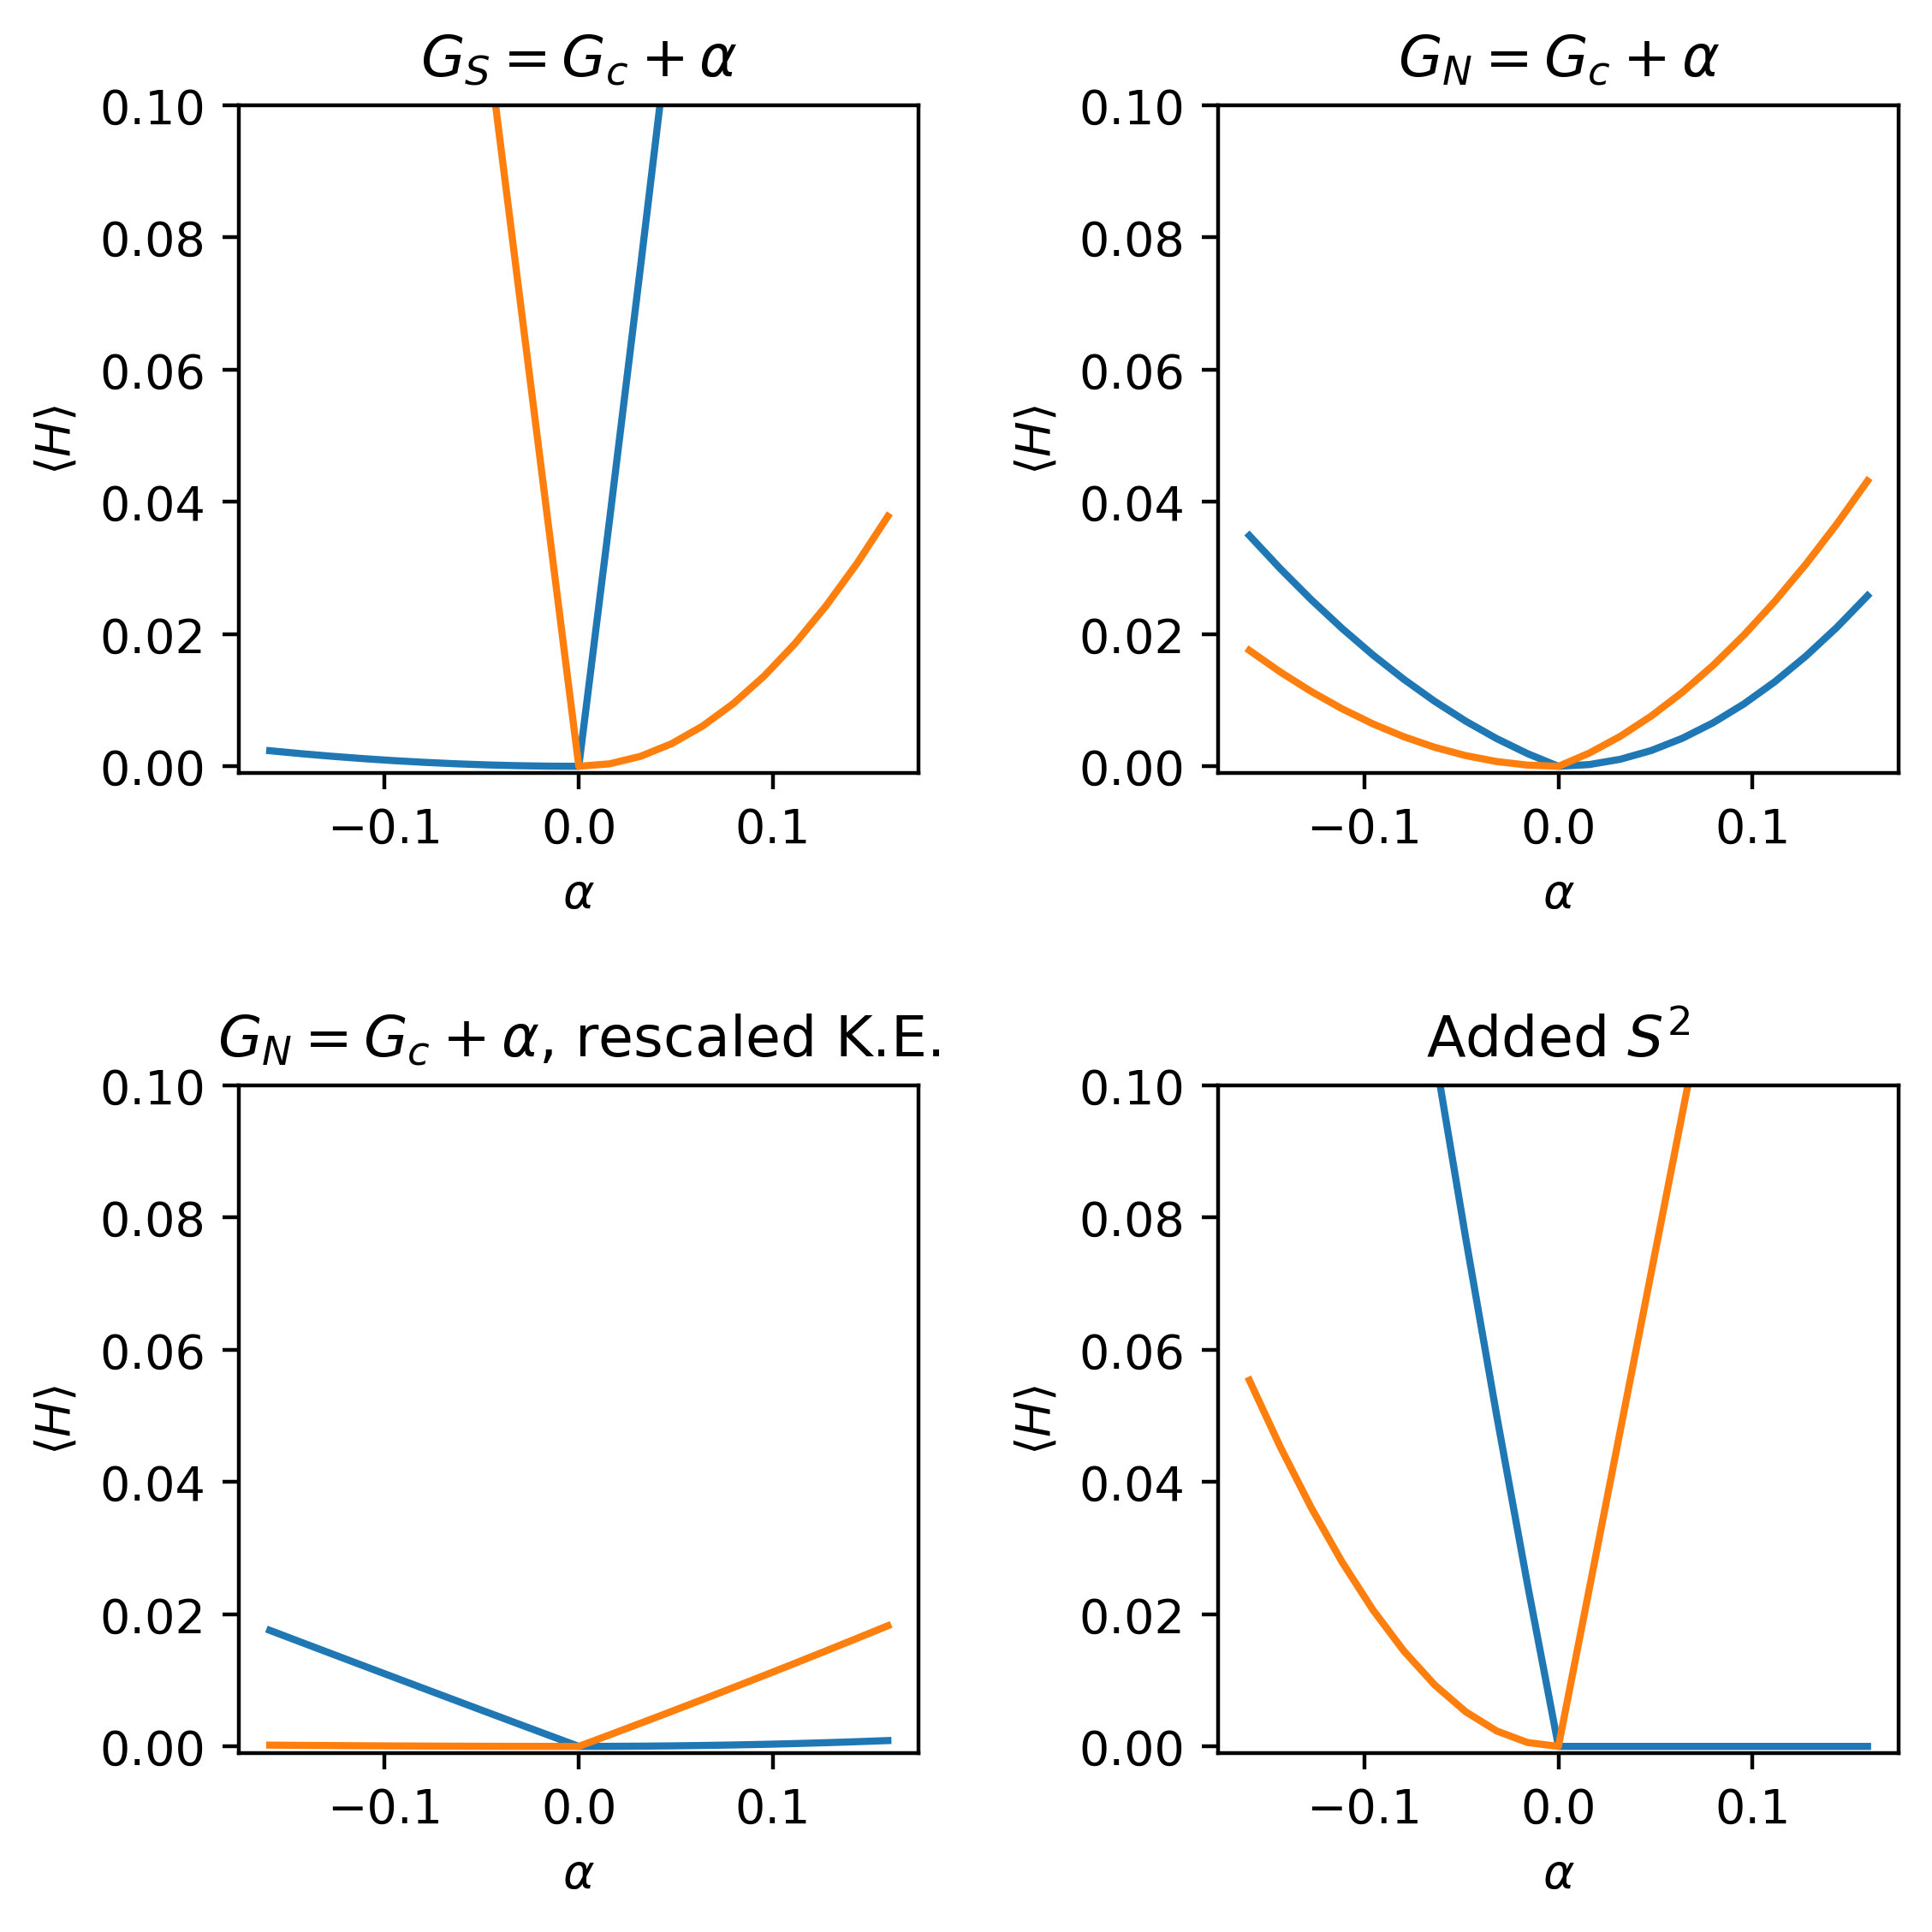

In [23]:
plt.figure(figsize=(6,6), dpi=400)
titles = [r'$G_T = G_c+\alpha$', r'$G_S = G_c+\alpha$', r'$G_N = G_c+\alpha$', 
          r'$G_N = G_c+\alpha$, rescaled K.E.',
          r'Added $S^2$']
for j in range(4):
    i = j+1
    la = labels[i]
    print(titles[i])

    plt.subplot(2,2,i)
    plt.plot(pscales, e1s[la]-e0s[la], label='S=0')
    # plt.plot(pscales, e3s[la], label='S=2')
    plt.plot(pscales, e2s[la]-e0s[la], label='S=4')
    print('S=0 diffs')
    print(e1s[la]-e0s[la])
    print('S=1 diffs')
    print(e2s[la]-e0s[la])
    # plt.scatter(pscales, e0s[la], label='$E_0$', marker='+', color='black')
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\langle H \rangle$')
    if i == 0:
        plt.legend()
    plt.title(titles[i])
    plt.ylim(-10**-3, 10**-1)

plt.tight_layout(pad=2.0)